Código que realiza la segmentación semántica para U-NET 

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
import os
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout,concatenate, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Adam
from keras.layers.core import SpatialDropout2D
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
trainx_rgb = sorted(glob.glob('./dataset/trainx/*.png'), key=numericalSort) #lee el conjunto de datos "trainx" contiene las imagenes rgb
X_train = np.array([np.array(Image.open(fname)) for fname in trainx_rgb])

trainy_mask = sorted(glob.glob('./dataset/trainyy/*.png'), key=numericalSort) # lee el conjunto de datos "trainyy 2 contiene las imagenes binarias
Y_train = np.array([np.array(Image.open(fname)) for fname in trainy_mask])

In [ ]:
#funcion para reajustar las imágenes a 256x192
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)

X_train_resized = []
Y_train_resized = []

for i in range(len(trainx_rgb)):
    X_train_resized.append(resize(trainx_rgb[i]))
    Y_train_resized.append(resize(trainy_mask[i]))
    
X_train = np.array([np.array(img) for img in X_train_resized])
Y_train = np.array([np.array(img) for img in Y_train_resized])

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

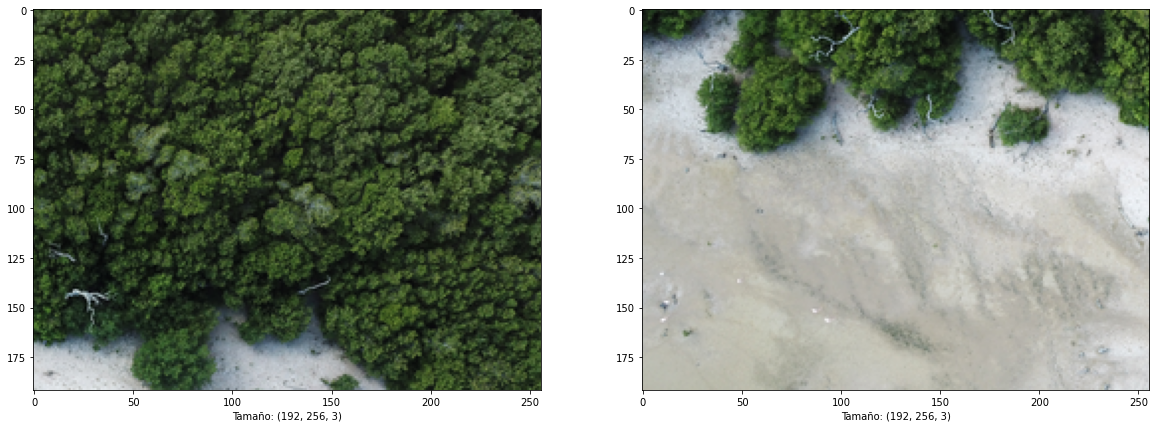

In [ ]:
#Tamaño de las imágenes de entrada
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.imshow(X_train[5])
plt.xlabel("Tamaño: "+str(np.array(X_train[1]).shape))
plt.subplot(1,2,2)
plt.imshow(X_train[10])
plt.xlabel("Tamaño: "+str(np.array(X_train[10]).shape))
plt.show()

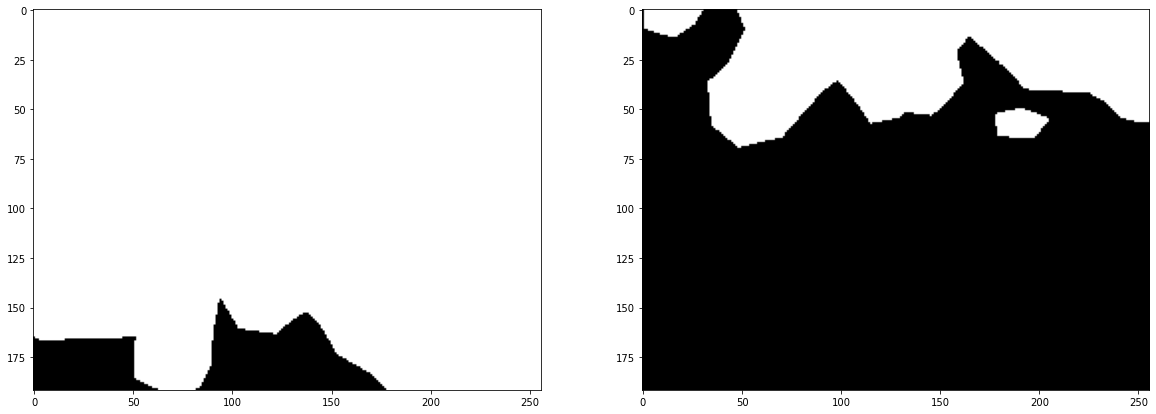

In [ ]:
#tamaño de las máscaras binarias
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.imshow(Y_train[5], cmap = plt.cm.binary_r)
plt.subplot(1,2,2)
plt.imshow(Y_train[10], cmap = plt.cm.binary_r)
plt.show()

In [8]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [9]:
#función para la métrica intersección sobre union
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [10]:
#función de métrica del coeficiente dice
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [11]:
#metrica de precision
#calcula la precision, es una metrica de clasificacion multinuvel de los elementos relevantes
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
#calcula la métrica recall
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [13]:
#calcular la métrica de exactitud
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [14]:
#función para unas técnicas de aumento de datos, rotación aleatoria y volteo horizontal
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('float32')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('float32')

In [ ]:
#aumento de datos con volteo vertical
def vertical_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 0)
    y_image = cv2.flip(y_image.astype('float32'), 0)
    return x_image, y_image.astype('float32')

In [15]:
def img_augmentation(x_train, y_train):

    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [16]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_vert = []
    y_vert = []
    x_both = []
    y_both = []
    x_nois = []
    #x_rotat = []
    #y_rotat =[]
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip), np.array(x_vert), np.array(y_vert), np.array(x_both), np.array(y_both)

In [25]:
x_rotated, y_rotated, x_flipped, y_flipped, x_vert, y_vert, x_both, y_both = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t, x_vert_t, y_vert_t, x_both_t, y_both_t = img_augmentation(x_test, y_test)

In [26]:
# Para el conjunto de dato de entrenamiento
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [29]:
print("Tamaño del conjunto de entrenamiento   : {}".format(len(x_train)))
print("Tamaño del conjunto de prueba       : {}".format(len(x_test)))
print("Tamaño del conjunto de validación : {}".format(len(x_val)))

Tamaño del conjunto de entrenamiento   : 3892
Tamaño del conjunto de prueba       : 95
Tamaño del conjunto de validación : 974


In [ ]:
# Numero de canales en cada imagen
canales_imagen = 3
salida_mascara = 1
# pesos preentrenados

In [ ]:
#funcion de una convolucion doble
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


In [ ]:
#funcion  de la arquitectura unet
def UNET_224(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'th':
        inputs = Input((canales_imagen, 192, 256))
        axis = 1
    else:
        inputs = Input((192, 256, canales_imagen))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(salida_mascara, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((192,256))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

In [ ]:
model, hist = UNET_224(1, 'unet_1_epoch.h5')

In [ ]:
dropout_val=0.50
if K.image_data_format() == 'th':
    inputs = Input((canales_imagen, 192, 256))
    axis = 1
else:
    inputs = Input((192, 256, canales_imagen))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(salida_mascara, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((192,256))(conv_final)

In [ ]:
#carga el modelo y las predicciones, carga el optimizador Adam y para la funcion d costo usamos Entropia cruzada
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(lr = 0.003), loss= ['binary_crossentropy']
                  , metrics=[iou, dice_coef, precision, recall, accuracy])

In [ ]:
model, hist = UNET_224(epochs_num= 120, savename= 'unet_120_epoch.h5')

In [ ]:
print('\n Estadisticas con 120 epocas sonre el conjunto de entrenamiento')
print('\n-------------Sobre el conjunto de entrenamiento--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('--------------------------')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Coef. Dice: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('--------------------------')



In [ ]:
print('\n -> Sobre el conjunto de prueba <-\n')
res = model_1.evaluate(x_test.astype('float32'), y_test.astype('float32'), batch_size= 18)
print('-------------------------')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Coef. Dice: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('--------------------------')



In [ ]:
print('\n -> Sobre el conjunto de validacion <- \n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('------------------------')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('-------------------------')

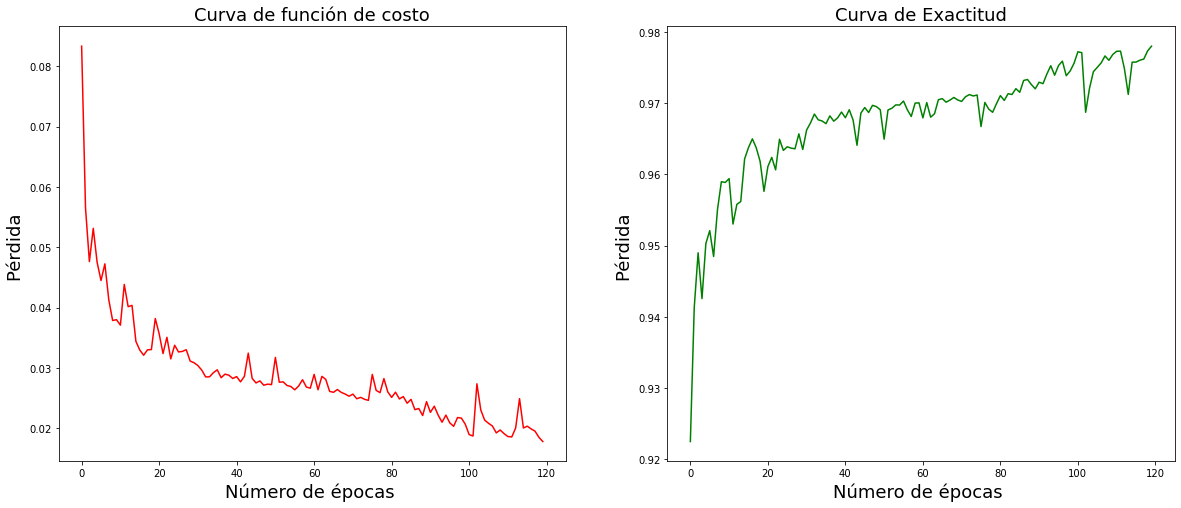

In [123]:
plt.figure(figsize=(20, 8))

#plt.suptitle('Estadistica de entrenamiento en el conjunto de entrenamiento', fontsize = 30, color='blue')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Curva de función de costo',fontsize = 18, color='black')
plt.xlabel("Número de épocas ",fontsize = 18, color='black')
plt.ylabel("Pérdida ",fontsize = 18, color='black')
#plt.subplot(2,3,2)
#plt.plot(hist.history['iou'], 'blue')
#plt.title('Jaccard Index',fontsize = 18, color='black')
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Curva de Exactitud',fontsize = 18, color='black')
plt.xlabel("Número de épocas ",fontsize = 18, color='black')
plt.ylabel("Pérdida ",fontsize = 18, color='black')
plt.show()
#plt.savefig('unet_train_1.png',dpi=200)

In [ ]:
plt.figure(figsize=(20,16))

plt.suptitle('Visualización de manglares predichas', fontsize = 18, color='black')

img_pred = model_1.predict(x_test[49].reshape(1,192,256,3))
plt.subplot(2,3,1)
plt.imshow(x_test[49])
plt.title('Imagen original')
plt.subplot(2,3,2)
plt.imshow(y_test[49], plt.cm.binary_r)
plt.title('Máscara etiquetada')
plt.subplot(2,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Máscara predicha')

img_pred = model_1.predict(x_test[21].reshape(1,192,256,3))
plt.subplot(2,3,4)
plt.imshow(x_test[21])
plt.title('Imagen original')
plt.subplot(2,3,5)
plt.imshow(y_test[21], plt.cm.binary_r)
plt.title('Máscara etiquetada')
plt.subplot(2,3,6)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Máscara predicha')
plt.show()

In [ ]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [ ]:
plt.figure(figsize=(24,16))

#plt.suptitle('Comparacion despues de la mejora', fontsize = 30, color='blue')

plt.subplot(2,3,1)
plt.imshow(x_test[21])
plt.title('Imagen original')
plt.subplot(2,3,2)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Máscara')
plt.subplot(2,3,3)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicción')

plt.subplot(2,3,4)
plt.imshow(x_test[19])
plt.title('Imagen Original')
plt.subplot(2,3,5)
plt.imshow(y_test[19],plt.cm.binary_r)
plt.title('Máscara')
plt.subplot(2,3,6)
plt.imshow(enhance(x_test[19]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicción')
plt.show()